In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Assume that we have a variable $Y$ such that $f_Y(D, e_Y) = \alpha + \delta D + e$.  
Now introduce a possible instrumental variable $Z$.

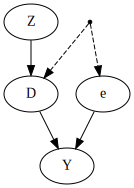

In [2]:
from causalgraphicalmodels import CausalGraphicalModel

iv = CausalGraphicalModel(
    nodes=["Z", "D", "Y", "e"],
    edges=[
        ("Z", "D"), 
        ("D", "Y"),
        ('e', 'Y')
    ],
    latent_edges=[
        ('e', 'D')
    ]
)

iv.draw()

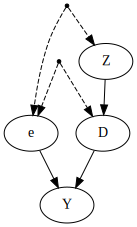

In [3]:
from causalgraphicalmodels import CausalGraphicalModel

iv_p = CausalGraphicalModel(
    nodes=["Z", "D", "Y", "e"],
    edges=[
        ("Z", "D"), 
        ("D", "Y"),
        ('e', 'Y')
    ],
    latent_edges=[
        ('e', 'D'),
        ('e', 'Z')
    ]
)

iv_p.draw()

In graphs $iv$ and $iv_p$ we are prevented from taking a least squares regression of $Y$ on $D$ by the backdoor path $D \leftrightarrow e \rightarrow Y$. Doing so would yield an inconsistent or unbiased estimate of the effect of $D$ on $Y$.  
Since $e$ is an unobserved error term, there are no variables satisfying the Back Door Criterion.

Potential instrumental variable $Z$ has a relationship with $Y$, through the path $Z \rightarrow D \rightarrow Y$.  
$Z$ does not generate statistical dependence with $Y$ through the path $Z \rightarrow D \leftrightarrow e \rightarrow Y$, because of collider $D$.  
In $iv_p$, the path $Z \leftrightarrow e \rightarrow Y$ does create statistical dependence. So $Z$ cannot be used in the scenario represented by that graph.

With the assumption that the effect of $D$ on $Y$ is constant $\delta$ we can obtain a consistent estimator by isolating the covariation between $D$ and $Y$ that is causal. Then we could ignore the noncausal covariation, as the result of common causes of $D$ and $e$.  
In $iv$, $Z$ serves as an isolated source of variation for $D$, but not in $iv_p$.

The Wald estimator, $\delta_{WALD}$ \~ $\frac{\mathbb{E}[Y|Z = 1] - \mathbb{E}[Y|Z = 0]}{\mathbb{E}[D|Z = 1] - \mathbb{E}[D|Z = 0]}$, provides a consistent estimate of the causal effect of $D$ on $Y$ (if $D$ is binary).

In the case of $iv_p$, the nonzero association between $Z$ and $e$ we do not find a consistent $\delta$ from the WALD estimator. It converges to $\delta$ plus a bias term of the net association between $Z$ and $e$.

### IV Demonstration 1

School voucher program to be examined in a metropolitan area.  
Randomly select 10 000 ninth graders and give them a standardized test. Collect scores as $\{y_i, d_i\}^{10 000}_{i = 1}$, for scores $Y$ and $D = 1$ if a student attended a private high school and $0$ otherwise.

10% of students win a voucher redeemable at a private high school. $z_i = 1$ for winners and $0$ otherwise.

In [4]:
units = 10000

p_z = .1 #probability of winning a voucher
Z = np.random.binomial(1, p_z, size=units)

e = np.random.normal(0, 5, size=units)

#Probability of attending private school is greater for lottery winners
p_d = .1 + Z / 10. + e / (abs(e).max() * 10)
D = np.random.binomial(1, p_d)

#Scores Y are of the form y = \alpha + \beta * D + e
Y = 50 + 10 * D + e

df = pd.DataFrame({'Z': Z, 'e': e, 'D': D, 'Y': Y})

In [5]:
df.head()

,Z,e,D,Y
0,0,0.167849,0,50.167849
1,0,3.620468,0,53.620468
2,0,2.036410,0,52.036410
3,1,5.584009,0,55.584009
4,0,1.542091,0,51.542091


**Note** This is on the low end of interdependence between an instrumental variable and causal state of interest.

In [6]:
df[['Z', 'D']].corr()

,Z,D
Z,1.000000,0.079097
D,0.079097,1.000000


This data generating process corresponds to $iv$, since $D$ lies on the path between $Z$ and $e$ there is no statistical dependence between them.  
We can estimate the causal effect of $D$ on $Y$ with the WALD estimator.

In [7]:
(df[df['Z'] == 1].Y.mean() - df[df['Z'] == 0].Y.mean()) / (df[df['Z'] == 1].D.mean() - df[df['Z'] == 0].D.mean())

10.586676179409892

That's quite close to the true effect, which from our data generating process was $\beta = 10$.

Now let's try to fit an OLS to recover $f_Y$.

In [8]:
from statsmodels.api import OLS, Logit

In [9]:
df['intercept'] = 1
instrument_model = Logit(df['D'], df[['Z', 'intercept']])
instrument_result = instrument_model.fit()

df['D_expected'] = instrument_result.predict(df[['Z', 'intercept']])
causal_model = OLS(df['Y'], df[['D_expected', 'intercept']])
result = causal_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.353300
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     19.07
Date:                Thu, 13 Dec 2018   Prob (F-statistic):           1.27e-05
Time:                        15:23:47   Log-Likelihood:                -32284.
No. Observations:               10000   AIC:                         6.457e+04
Df Residuals:                    9998   BIC:                         6.459e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D_expected    10.5867      2.424      4.367      0.000       5.835      15.338
intercept     49.9967      0.284    175.774      0.000      49.439      50.554
==============================================================================
Omnibus:                      396.136   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              461.779
Skew:                           0.469   Prob(JB):                    5.32e-101
Kurtosis:                       3.480   Cond. No.                         40.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We've just about got it. The coefficients for D_expected and intercept are close to the true values of 10 and 50, respectively.

Using statsmodels built-in 2SLS

In [10]:
from statsmodels.sandbox.regression.gmm import IV2SLS

In [11]:
model = IV2SLS(df['Y'], df[['D', 'intercept']], instrument=df[['Z', 'intercept']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.339
Model:                         IV2SLS   Adj. R-squared:                  0.339
Method:                     Two Stage   F-statistic:                     28.81
                        Least Squares   Prob (F-statistic):           8.16e-08
Date:                Thu, 13 Dec 2018                                         
Time:                        15:23:47                                         
No. Observations:               10000                                         
Df Residuals:                    9998                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D             10.5867      1.972      5.368      0.000       6.720      14.453
intercept     49.9967      0.231    216.033      0.000      49.543      50.450
==============================================================================
Omnibus:                        1.254   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.534   Jarque-Bera (JB):                1.223
Skew:                          -0.014   Prob(JB):                        0.543
Kurtosis:                       3.047   Cond. No.                         3.19
==============================================================================
"""

Now lets introduce statistical dependence between $Z$ and $e$ through a confounder $A$.

In [12]:
units = 10000

A = np.random.normal(size=units) #Confounder

p_z = .1 + A / (10 * abs(A).max()) #probability of winning a voucher
Z = np.random.binomial(1, p_z, size=units)

e = np.random.normal(5 * A, 5, size=units)

#Probability of attending private school is greater for lottery winners
p_d = .1 + Z / 10. + e / (abs(e).max() * 10)
D = np.random.binomial(1, p_d)

#Scores Y are of the form y = \alpha + \beta * D + e
Y = 50 + 10 * D + e

df = pd.DataFrame({'A': A, 'Z': Z, 'e': e, 'D': D, 'Y': Y})

In [13]:
df.corr()

,A,Z,e,D,Y
A,1.000000,0.065932,0.699773,0.078160,0.647928
Z,0.065932,1.000000,0.050140,0.092346,0.080710
e,0.699773,0.050140,1.000000,0.095090,0.919350
D,0.078160,0.092346,0.095090,1.000000,0.479079
Y,0.647928,0.080710,0.919350,0.479079,1.000000


Now we have a correlation between $Z$ and $e$.

In [14]:
df['intercept'] = 1
instrument_model = Logit(df['D'], df[['Z', 'intercept']])
instrument_result = instrument_model.fit()

df['D_expected'] = instrument_result.predict(df[['Z', 'intercept']])
causal_model = OLS(df['Y'], df[['D_expected', 'intercept']])
result = causal_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.350527
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     65.56
Date:                Thu, 13 Dec 2018   Prob (F-statistic):           6.31e-16
Time:                        15:23:47   Log-Likelihood:                -34991.
No. Observations:               10000   AIC:                         6.999e+04
Df Residuals:                    9998   BIC:                         7.000e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D_expected    22.1134      2.731      8.097      0.000      16.760      27.467
intercept     48.6754      0.321    151.782      0.000      48.047      49.304
==============================================================================
Omnibus:                      139.914   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.349
Skew:                           0.274   Prob(JB):                     6.11e-33
Kurtosis:                       3.236   Cond. No.                         34.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The estimated coefficient of $D$ is very biased now, since we are picking some of the causal dependence through the backdoor path created by $A$.  
We can alleviate this by conditioning on $A$ in our OLS.

In [15]:
df['D_expected'] = instrument_result.predict(df[['Z', 'intercept']])
causal_model = OLS(df['Y'], df[['D_expected', 'A', 'intercept']]) #Include A in the regression
result = causal_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     3638.
Date:                Thu, 13 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:23:47   Log-Likelihood:                -32289.
No. Observations:               10000   AIC:                         6.458e+04
Df Residuals:                    9997   BIC:                         6.461e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D_expected    10.4545      2.089      5.004      0.000       6.359      14.550
A              5.1484      0.061     84.642      0.000       5.029       5.268
intercept     50.0189      0.245    203.917      0.000      49.538      50.500
==============================================================================
Omnibus:                      308.650   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.171
Skew:                           0.412   Prob(JB):                     2.49e-76
Kurtosis:                       3.396   Cond. No.                         34.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That's a lot better! Understanding the causal graph allowed us to recover the data generating process, even with the existence of a confounder.

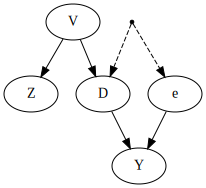

In [16]:
iv_surrogate = CausalGraphicalModel(
    nodes=["Z", "V", "D", "Y", "e"],
    edges=[
        ("V", "Z"),
        ("V", "D"), 
        ("D", "Y"),
        ('e', 'Y')
    ],
    latent_edges=[
        ('e', 'D')
    ]
)

iv_surrogate.draw()

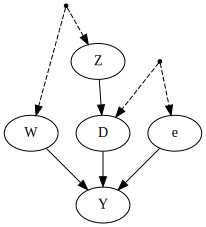

In [17]:
iv_conditional = CausalGraphicalModel(
    nodes=["Z", "W", "D", "Y", "e"],
    edges=[
        ("Z", "D"), 
        ("D", "Y"),
        ('e', 'Y'),
        ("W", "Y")
    ],
    latent_edges=[
        ('e', 'D'),
        ('W', 'Z')
    ]
)

iv_conditional.draw()

In both $iv_{surrogate}$ and $iv_{conditional}$, $Z$ is a valid instrumental variable. In the former, $V$ is unobserved, but $Z$ is a surrogate which has an association with $D$ even if it is not a direct cause of $D$. A possible complication in this case is a weak association between $Z$ and $D$. In the latter, $Z$ has an association with $Y$ through a path other than that through $D$, $Z \leftrightarrow W \rightarrow Y$. But this backdoor path can be blocked by conditioning on $W$ (see below) during estimation.

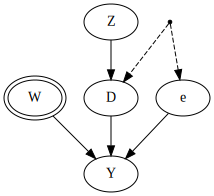

In [18]:
iv_c_do = iv_conditional.do('W')
iv_c_do.draw()

### Examples

Causal effect of interest: years of schooling on subsequent earnings  
IVs: proximity to college, regional and temporal variation in school construction, tuition at local colleges, temporal variation in minimum school-leaving age, quarter of birth.  

In [24]:
units = 10000

V = np.random.binomial(1, .5, size=units) #Parental graduation (not realistic because of causal effects on childrens' earnings) 

Z = np.random.exponential(1.5 - V, size=units) #Distance from some college
#College-educated parents are expected to live closer to colleges

p_d = .15 - V / 10  
D = np.random.geometric(p_d) #Years of schooling
#Children of college-educated parents are expected to attend school for longer

e = np.random.normal(5, size=units) #Individual effects

Y = 50 + D + e #Earnings

df = pd.DataFrame({'V': V, 'Z': Z, 'D': D, 'e': e, 'Y': Y})

In [25]:
df[['Z', 'D']].corr()

,Z,D
Z,1.000000,-0.180242
D,-0.180242,1.000000


Even though there is no causal relationship between $Z$ and $D$, since both are caused by $V$ we get a statistical association.

First we require that $Cov(e, Z) = 0$. If that hol

In [33]:
df[['e', 'Z']].corr()

,e,Z
e,1.000000,0.003654
Z,0.003654,1.000000


In [32]:
df[['Y', 'Z']].corr().Y.Z / df[['D', 'Z']].corr().D.Z

0.9974195578519796